# **Projet MACS207b**  - Filtrage
- Rendu le 10/06/2022

**Timothée LY, Louis PERSONNAZ**

# 1 - Présentation du problème

**Hypothèses :**

2 processus de Poisson indépendants $N_a$ et $N_b$, on observe $N_a$ puis $N_b$ après $\tau$
- $\tau \sim \mathcal{E}(\mu)$ avec $\mu = 0.2$ et $\tau$ indépendant de $N_a$, $N_b$
- $a = 5$ et $b = 10$

**But :** on veut estimer $\tau$ à travers l'observation des instants de saut du processus ponctuel "concaténé" $N$

**Notations :** $\tau$ a pour densité $f$ et fonction de répartition $F$ 

# 2 - Résolution et implémentation

On calcule la fonction $h$ donnée par :
$$h(s) = \dfrac{f(s)}{1-F(s)}$$

Pour une loi exponentielle d'intensité $\mu$: 

$\forall s \in \mathbb{R}, \ f(s) = \mu e^{-\mu s} \mathbb{1}_{\mathbb{R}^+}(s)$

$\forall s \in \mathbb{R}, \ F(s) = (1 - e^{-\mu s}) \mathbb{1}_{\mathbb{R}^+}(s)$

d'où l'on tire

$$
\begin{align*}
\forall s \in \mathbb{R}^+, \quad h(s)
&= \dfrac{ \mu e^{-\mu s}}{1-(1 - e^{-\mu s})} \\
&= \dfrac{ \mu e^{-\mu s}}{e^{-\mu s}} \\
&= \mu
\end{align*}
$$

<u> Application numérique :</u>  $h(s) = 0.2 \, \mathbb{1}_{s \ge 0}$

### Imports

In [1]:
from tqdm import tqdm
import numpy as np
from scipy.integrate import odeint
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
sns.set()
sns.set_palette("hls")

### Graine (pour reproductibilité)

In [2]:
seed = 2381
rng = np.random.default_rng(seed)

### Simulation numérique

In [3]:
mu = 0.2
h = lambda s : mu if s > 0 else 0
a = 5
b = 10

In [4]:
Z = lambda t, tau : 1 if (tau <= t) else 0
N = lambda a, b, t, tau : (a + (b-a) * Z(t, tau)) * t

In [5]:
def poisson_proc(lmbda, orig, horiz, rng):
    """
    génère des instants d'arrivée d'un processus de Poisson
    lmbda: intensité
    orig: origine des temps
    horiz: horizon des temps
    """  
    arrivals = []
    t = orig
    while t < horiz:
        t = t - np.log(rng.random()) / lmbda
        arrivals.append(t)
    
    return np.sort(arrivals[:-1])   

In [6]:
def trajectory(a, b, beg, end, rng, n=1000, disp=False):
    """
    affiche la trajectoire d'une observation aléatoire
    a, b: intensités
    beg, end: bornes des temps
    n: nombre de points pour l'affichage
    disp: afficher la trajectoire
    """
    tau = beg + rng.exponential(1/mu) # tirer un tau aléatoire dans [beg, +inf[
    end = max(end, 2 + np.ceil(tau))  # éloigner l'horizon si tau trop grand
    # générer les temps d'arrivée avant et après tau
    arrivals = np.concatenate((poisson_proc(a, beg, tau, rng),
                               poisson_proc(b, tau, end, rng)))
    
    if disp:
        plt.figure(figsize=(10, 5))
        plt.step(arrivals, np.arange(arrivals.size))
        plt.axvline(tau, linestyle=':', c='olivedrab')
        plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
        plt.xlim(beg, max(end, tau))
        plt.title(fr"Une trajectoire avec $\tau =${tau:.2f}")
        plt.ylabel(r"$N(t)$")
        plt.xlabel(r"$t$")
        plt.show()
    
    return beg, end, arrivals, tau

In [7]:
beg, end = 0, 10

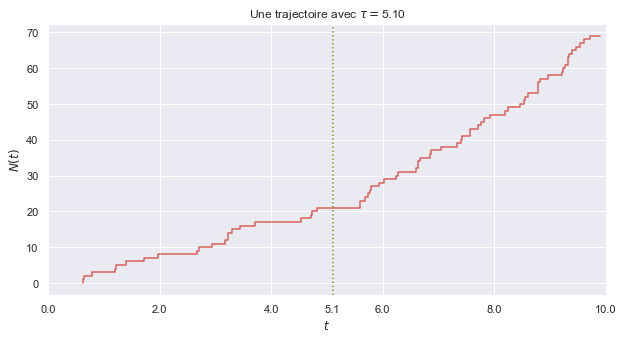

In [8]:
beg, end, arrivals, tau = trajectory(a, b, beg, end, rng, disp=True)

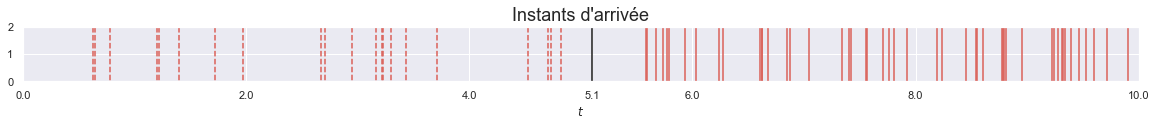

In [9]:
plt.figure(figsize=(20, 1))
plt.eventplot(arrivals[arrivals < tau].flatten(), linelengths=2, linestyles='dashed')
plt.eventplot(arrivals[arrivals > tau].flatten(), linelengths=2, linestyles='solid')
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title("Instants d'arrivée", fontsize=18)
plt.show()

### Résolution par approche théorique

On peut montrer que (cf. exercice 2.2 — Détection de changement de régime du poly) :
- les instants de saut de $Z$ sont ceux de $N$
-
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t [h(s) - (b-a)\hat{Z}(s)] (1 - \hat{Z}(s)) \, \mathrm{d} s$$
d'où
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}'(t) = [h(t) - (b-a)\hat{Z}(t)] (1 - \hat{Z}(t))$$
-
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a) \hat{Z}(T_n^-) (1-\hat{Z}(T_n^-))}{a + (b-a) \hat{Z}(T_n^-)}$$

In [10]:
derivative = lambda z, t : (h(t) - (b-a)*z) * (1-z)

In [11]:
def flatten_to_array(l):
    t = []
    for e in l:
        if isinstance(e, float):
            t.append(e)
        if isinstance(e, np.ndarray):
            t += e.tolist()
    return np.array(t)

In [12]:
def saut(ZTn_, a, b):
    return (b-a) * ZTn_ * (1 - ZTn_) / (a + (b-a) * ZTn_)

In [13]:
def Z_hat(arrivals, beg, end):
    """
    calcule l'estimation Z_hat à partir de l'observation des sauts
    """
    m = arrivals.size
    ts = []     # temps
    Z_hats = [] # valeurs de Z_hat
    z0 = 0      # valeur initiale
    
    # segment [beg, T_0]
    n_points = int(np.ceil(50 * max(a,b) * arrivals[0]))
    t = np.linspace(0, arrivals[0], n_points, endpoint=False)
    ts.append(t)
    Z_hats.append(odeint(derivative, z0, t).ravel())
    ts.append(arrivals[0]) # rajouter ce temps exclu ci-dessus
    Z_hats.append(Z_hats[-1][-1] + saut(Z_hats[-1][-1], a, b)) # prendre pour ZTn_ la dernière valeur estimée
    
    for n in range(m-1):
        # segment [T_n, T_{n+1}]
        n_points = int(np.ceil(50 * max(a,b) * (arrivals[n+1] - arrivals[n])))
        t = np.linspace(arrivals[n], arrivals[n+1], n_points, endpoint=False)
        ts.append(t)
        Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
        ts.append(arrivals[n+1])
        Z_hats.append(Z_hats[-1][-1] + saut(Z_hats[-1][-1], a, b))
        
    # segment [T_{m-1}, end]
    n_points = int(np.ceil(50 * max(a,b) * (end - arrivals[-1])))
    t = np.linspace(arrivals[-1], end, n_points, endpoint=True)
    ts.append(t)
    Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
    
    return flatten_to_array(ts), flatten_to_array(Z_hats)

In [14]:
ts, Z_hats = Z_hat(arrivals, beg, end)

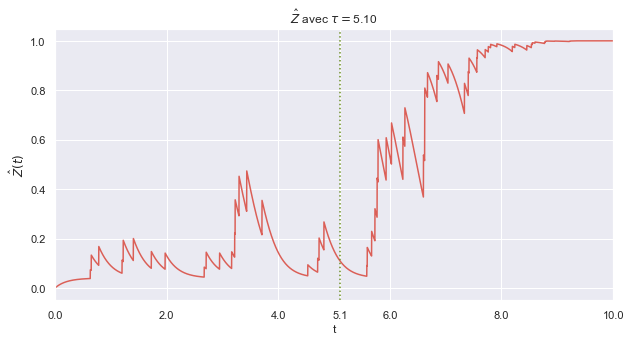

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(ts, Z_hats)
plt.axvline(tau, linestyle=':', c='olivedrab')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.title(fr"$\hat{{Z}}$ avec $\tau =${tau:.2f}")
plt.ylabel(r'$\hat{Z}(t)$')
plt.xlabel("t")
plt.show()

In [16]:
N = 30 # caractérise la taille de la fenêtre de lissage

# filtrer l'estimateur Z_hat
filt = np.hanning(Z_hats.size // N)
filt /= np.sum(filt) # normaliser le filtre
Z_hats_filt = lfilter(filt, [1], Z_hats)

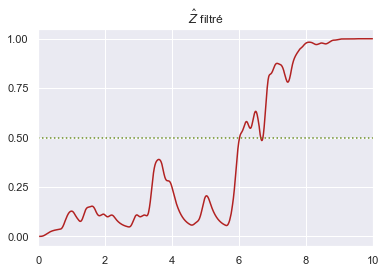

In [17]:
plt.plot(ts, Z_hats_filt, c='firebrick')
plt.xlim(beg, end)
plt.axhline(.5, linestyle=':', c='olivedrab')
plt.yticks(np.linspace(0, 1, 5))
plt.title(r"$\hat{Z}$ filtré")
plt.show()

In [18]:
# indices des upcrossings de 0.5
upcrossing_indices = np.where((Z_hats_filt[:-1] < .5) & (Z_hats_filt[1:] > .5))[0]

# prendre la moyenne des temps d'upcrossing
if upcrossing_indices.size > 0:
    tau_Z_hat = np.mean(ts[upcrossing_indices])
else: # Z_hat n'est jamais monté très haut...
    tau_Z_hat = ts[np.argmax(Z_hats_filt)] # on prend le pic de Z_hat

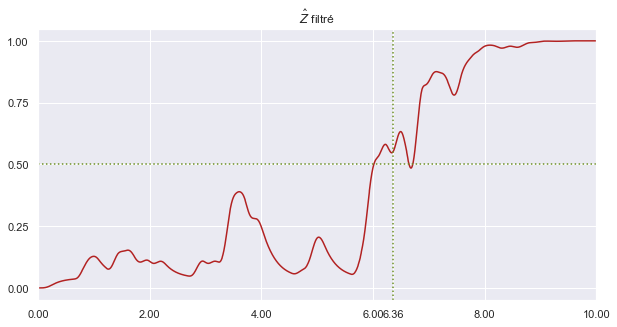

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(ts, Z_hats_filt, c='firebrick')
plt.axhline(.5, linestyle=':', c='olivedrab')
plt.axvline(tau_Z_hat, linestyle=':', c='olivedrab')
plt.xticks(list(plt.xticks()[0]) + [tau_Z_hat]) # ajouter 1 tick à l'abscisse tau_Z_hat
plt.xlim(beg, end)
plt.yticks(np.linspace(0, 1, 5))
plt.title(r"$\hat{Z}$ filtré")
plt.show()

### Résolution par approche Machine Learning : K-means

On introduit les features "temps d'arrivée" et "temps d'attente" pour chaque arrivée.

Puis on effectue un $k$-means avec $k=2$ pour tenter de séparer les 2 sous-processus.

Nous avons tenté plusieurs heuristiques pour déterminer $\tau$ après un $k$-means où $k>2$ (2ème $k$-means sur le cardinal des clusters, estimateur de l'intensité sur les clusters cumulés...) mais elles se sont avérées peu fiables et assez complexes.

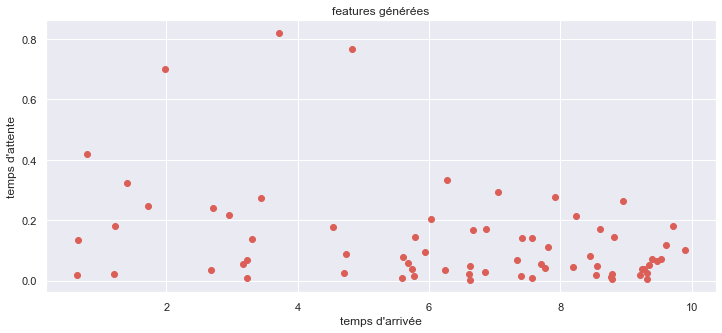

In [20]:
plt.figure(figsize=(12, 5))
waits = arrivals[1:] - arrivals[:-1]
waits_ = np.concatenate((waits, [1/b]))
plt.scatter(arrivals, waits_)
plt.title("features générées")
plt.xlabel("temps d'arrivée")
plt.ylabel("temps d'attente")
plt.show()

In [21]:
n_clusters = 2
features = np.stack((arrivals, waits_), axis=1)
kmeans = KMeans(n_clusters=n_clusters, n_init=30, random_state=seed)
kmeans.fit(features)

KMeans(n_clusters=2, n_init=30, random_state=2381)

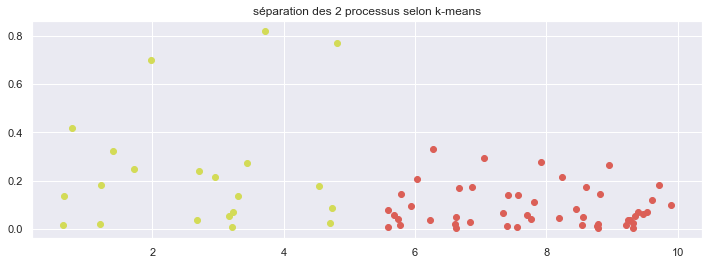

In [22]:
palette = sns.color_palette() # palette de couleurs
plt.figure(figsize=(12, 4))
for n in range(n_clusters):
    plt.scatter(arrivals[kmeans.labels_ == n],
                waits_[kmeans.labels_ == n],
                color=palette[n])
plt.title("séparation des 2 processus selon k-means")
plt.show()

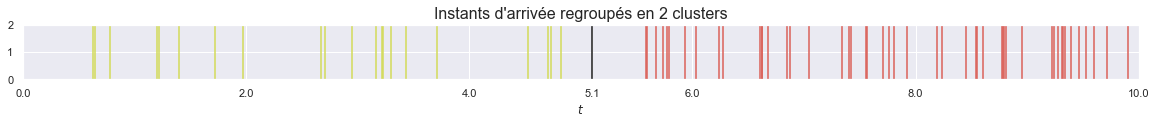

In [23]:
palette = sns.color_palette() # palette de couleurs
plt.figure(figsize=(20, 1))
for n in range(n_clusters):
    plt.eventplot(arrivals[kmeans.labels_ == n],
                  linelengths=2,
                  colors=palette[n])
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title(f"Instants d'arrivée regroupés en {n_clusters} clusters", fontsize=16)
plt.show()

On fait le choix arbitraire mais pas aberrant de prendre pour l'estimation de $\tau$ le milieu du segment formé par les extremités haute et basse (respectivement) des 2 clusters.

In [24]:
# calcul des bornes pour les 2 clusters
# (l'ordre des 2 clusters n'est pas déterministe)
min0 = np.min(arrivals[kmeans.labels_ == 0])
max0 = np.max(arrivals[kmeans.labels_ == 0])
min1 = np.min(arrivals[kmeans.labels_ == 1])
max1 = np.max(arrivals[kmeans.labels_ == 1])
sorted_bounds = np.sort([min0, max0, min1, max1])

# calcul de l'estimation de tau
tau_kmeans = (sorted_bounds[1] + sorted_bounds[2]) / 2

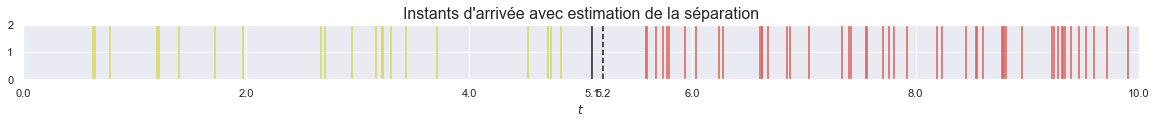

In [25]:
palette = sns.color_palette() # palette de couleurs
plt.figure(figsize=(20, 1))
for n in range(n_clusters):
    if kmeans.labels_[n] == 1:
        plt.eventplot(arrivals[kmeans.labels_ == n],
                      linelengths=2,
                      colors=palette[n])
    else:
        plt.eventplot(arrivals[kmeans.labels_ == n],
                      linelengths=2,
                      colors=palette[n])
plt.axvline(tau_kmeans, linestyle='--', c='k')
plt.xticks(list(plt.xticks()[0]) + [tau_kmeans]) # ajouter 1 tick à l'abscisse tau_kmeans
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title(f"Instants d'arrivée avec estimation de la séparation", fontsize=16)
plt.show()

<hr>

**Tentatives supplémentaires avec $k$-means**

_Idée_:

On estime $k > 2$ clusters, sur chacun de ces clusters on estime l'intensité (locale) et on tag ce cluster étant d'intensité $a$ ou $b$ suivant le min de la distance avec $a$ et $b$ (norme $L^1$ dans $\mathbb{R}$). On calcule `max_a` le dernier instant d'arrivée taggé d'intensité $a$ et `min_b` le premier instant d'arrivée taggé d'intensité $b$. Le $\tau$ estimé est la moyenne de ces 2 valeurs.

In [26]:
# pour illustrer le comportement de l'algo sur un cas particulier
seed = 2022
rng = np.random.default_rng(seed)
beg, end, arrivals, tau = trajectory(a, b, beg, end, rng, disp=False)
waits = arrivals[1:] - arrivals[:-1]
waits_ = np.concatenate((waits, [1/b]))

In [27]:
n_clusters = 8
features = np.stack((arrivals, waits_), axis=1)
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(features)

KMeans(random_state=2022)

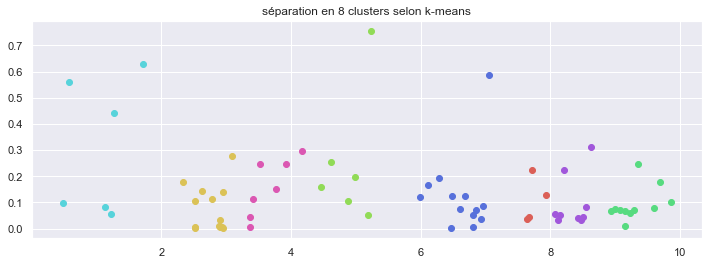

In [28]:
palette = sns.color_palette(palette='hls', n_colors=n_clusters) # palette de couleurs
plt.figure(figsize=(12, 4))
for n in range(n_clusters):
    plt.scatter(arrivals[kmeans.labels_ == n],
                waits_[kmeans.labels_ == n],
                color=palette[n])
plt.title(f"séparation en {n_clusters} clusters selon k-means")
plt.show()

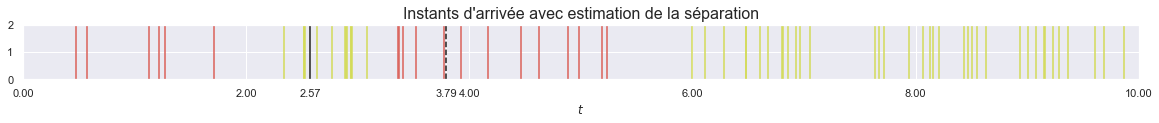

In [29]:
palette = sns.color_palette() # palette de couleurs
plt.figure(figsize=(20, 1))
max_a = beg
min_b = end
for n in range(n_clusters):
    cluster_wait_mean = np.mean(waits_[kmeans.labels_ == n])
    est_cat = np.argmin([abs(cluster_wait_mean-1/a), abs(cluster_wait_mean-1/b)])
    if est_cat == 0: # intensité a
        max_a = max(max_a, np.max(arrivals[kmeans.labels_ == n]))
    if est_cat == 1: # intensité b
        min_b = min(min_b, np.min(arrivals[kmeans.labels_ == n]))
    plt.eventplot(arrivals[kmeans.labels_ == n],
                  linelengths=2,
                  colors=palette[est_cat])
    
# calcul de l'estimation de tau
tau_kmeans = (max_a + min_b) / 2

plt.axvline(tau_kmeans, linestyle='--', c='k')
plt.xticks(list(plt.xticks()[0]) + [tau_kmeans]) # ajouter 1 tick à l'abscisse tau_kmeans
plt.axvline(tau, c='k')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.ylim(0, 2)
plt.xlabel(r"$t$")
plt.title(f"Instants d'arrivée avec estimation de la séparation", fontsize=16)
plt.show()

### Analyse statistique

In [30]:
seed = 42

In [31]:
def repeat_ests(a, b, beg, end, n_repeats, seed, method):
    """
    répète des estimations du temps tau
    
    a, b: intensités
    beg, end: bornes des temps
    n_repeats: nombre de répétitions à simuler
    seed: graine
    method: méthode à utiliser pour l'estimation
    """
    
    # re-instancier le rng pour résultats reproduisibles sur les mêmes tirages
    rng = np.random.default_rng(seed)
    
    # pour stocker les résultats
    arrivals_l = []
    taus_l     = []
    est_taus_l = []
    
    for repeat in tqdm(range(n_repeats)):
        beg_, end_, arrivals, tau = trajectory(a, b, beg, end, rng)
        arrivals_l.append(arrivals)
        taus_l.append(tau)
    
        if method == "Z_hat":
            ts, Z_hats = Z_hat(arrivals, beg_, end_)
            
            filt = np.hanning(Z_hats.size // 30)
            filt /= np.sum(filt)
            Z_hats_filt = lfilter(filt, [1], Z_hats)
            upcrossing_indices = np.where((Z_hats_filt[:-1] < .5) & (Z_hats_filt[1:] > .5))[0]
            
            if upcrossing_indices.size > 0:
                tau_Z_hat = np.mean(ts[upcrossing_indices])
            else:
                tau_Z_hat = ts[np.argmax(Z_hats_filt)]
            
            est_taus_l.append(tau_Z_hat)
            
        if method == "2means":
            waits = arrivals[1:] - arrivals[:-1]
            waits_ = np.concatenate((waits, [1/b]))

            features = np.stack((arrivals, waits_), axis=1)
            kmeans = KMeans(n_clusters=2, random_state=seed)
            kmeans.fit(features)

            min0 = np.min(arrivals[kmeans.labels_ == 0])
            max0 = np.max(arrivals[kmeans.labels_ == 0])
            min1 = np.min(arrivals[kmeans.labels_ == 1])
            max1 = np.max(arrivals[kmeans.labels_ == 1])
            sorted_bounds = np.sort([min0, max0, min1, max1])
            tau_kmeans = (sorted_bounds[1] + sorted_bounds[2]) / 2
            
            est_taus_l.append(tau_kmeans)
            
        if method == "8means":
            waits = arrivals[1:] - arrivals[:-1]
            waits_ = np.concatenate((waits, [1/b]))

            features = np.stack((arrivals, waits_), axis=1)
            kmeans = KMeans(n_clusters=8, random_state=seed)
            kmeans.fit(features)
            
            max_a = beg_
            min_b = end_
            for n in range(8):
                cluster_wait_mean = np.mean(waits_[kmeans.labels_ == n])
                est_cat = np.argmin([abs(cluster_wait_mean-1/a), abs(cluster_wait_mean-1/b)])
                if est_cat == 0: # intensité a
                    max_a = max(max_a, np.max(arrivals[kmeans.labels_ == n]))
                if est_cat == 1: # intensité b
                    min_b = min(min_b, np.min(arrivals[kmeans.labels_ == n]))
            tau_kmeans = (max_a + min_b) / 2
            
            est_taus_l.append(tau_kmeans)
    
    return taus_l, est_taus_l

In [32]:
def stat_summary(taus_l, est_taus_l, method):
    """
    affiche un résumé statistique pour l'estimation de tau
    
    taus_l: liste des tau générés
    est_taus_l: liste des taus estimés
    method: méthode de génération
    """
    
    # conversion en arrays
    taus_arr = np.array(taus_l)
    est_taus_arr = np.array(est_taus_l)
    
    # erreur
    error = taus_arr - est_taus_arr
    
    print(f"----- Méthode: {method} -----")
    print(f"{len(taus_l)} estimations")
    print(f"biais: {np.mean(error):.2f}")
    print(f"variance: {np.var(error):.2f}")
    print(f"mu={mu}\na={a}\nb={b}")
    
    # histogramme de l'erreur sur tau
    fig = plt.figure(figsize=(10, 3))
    if method == "2means":
        color = "firebrick"
    if method == "8means":
        color = "teal"
    if method == "Z_hat":
        color = "olivedrab"
    plt.hist(error, bins=50, color=color)
    plt.title(fr"$\tau - \hat{{\tau}}$ avec {method}")
    plt.show()

In [33]:
a = 5
b = 10
beg = 0
end = 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:46<00:00, 42.85it/s]


----- Méthode: 2means -----
2000 estimations
biais: -0.77
variance: 12.99
mu=0.2
a=5
b=10


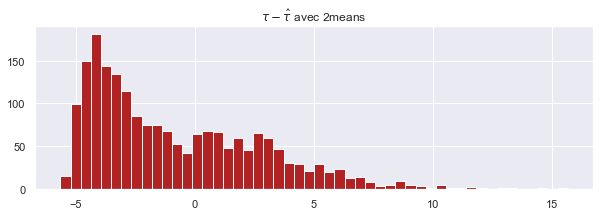

In [34]:
taus_l_2means, est_taus_l_2means = repeat_ests(a, b, beg, end, 2000, seed, "2means")
stat_summary(taus_l_2means, est_taus_l_2means, "2means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:04<00:00, 31.14it/s]


----- Méthode: 8means -----
2000 estimations
biais: 0.38
variance: 5.95
mu=0.2
a=5
b=10


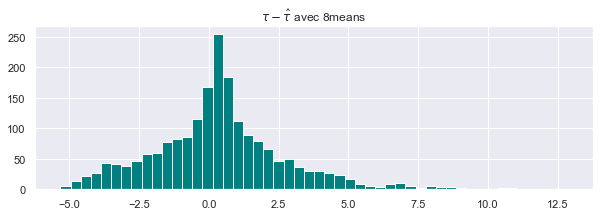

In [35]:
taus_l_8means, est_taus_l_8means = repeat_ests(a, b, beg, end, 2000, seed, "8means")
stat_summary(taus_l_8means, est_taus_l_8means, "8means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.66it/s]


----- Méthode: Z_hat -----
2000 estimations
biais: 0.01
variance: 5.05
mu=0.2
a=5
b=10


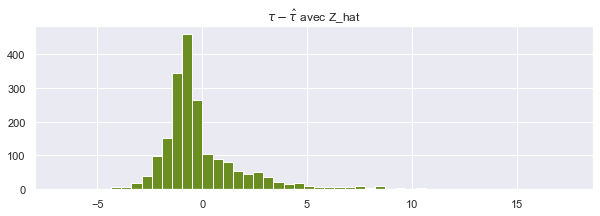

In [36]:
taus_l_Zhat, est_taus_l_Zhat = repeat_ests(a, b, beg, end, 2000, seed, "Z_hat")
stat_summary(taus_l_Zhat, est_taus_l_Zhat, "Z_hat")

L'approche théorique donne des résultats meilleurs (on s'y attendait un peu!):
- le biais empirique est presque nul
- la variance est bien plus basse que pour 2-means et un peu meilleur que pour 8-means

La seconde approche avec $k$-means, où $k>2$ a porté ses fruits, l'estimateur est plus "élégant" dans le sens où la distribution de l'erreur a plus une forme gaussienne.

Même si le biais empirique est proche de 0, notre algorithme basé sur $\hat{Z}$ a tendance à estimer $\hat{\tau}$ avec du retard plutôt que de l'avance. C'est visible sur la forme de l'histogramme : les plus hauts pics sont à gauche de 0.

#### Robustesse des 2 approches à des changements de paramètres

- où l'écart entre $a$ et $b$ est modifié de sorte à faciliter la séparation

In [37]:
mu = 0.2
a = 5
b = 25
beg = 0
end = 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 38.11it/s]


----- Méthode: 2means -----
2000 estimations
biais: -1.31
variance: 11.48
mu=0.2
a=5
b=25


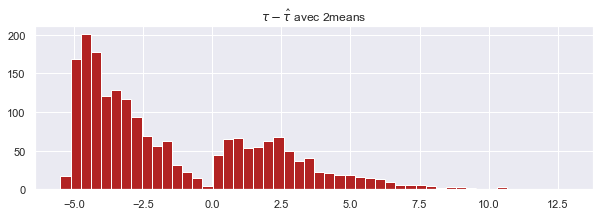

In [38]:
taus_l_2means, est_taus_l_2means = repeat_ests(a, b, beg, end, 2000, seed, "2means")
stat_summary(taus_l_2means, est_taus_l_2means, "2means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:27<00:00, 22.85it/s]


----- Méthode: 8means -----
2000 estimations
biais: 0.74
variance: 0.71
mu=0.2
a=5
b=25


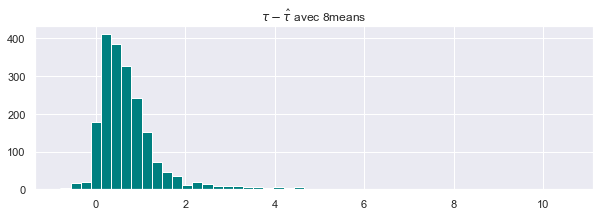

In [39]:
taus_l_8means, est_taus_l_8means = repeat_ests(a, b, beg, end, 2000, seed, "8means")
stat_summary(taus_l_8means, est_taus_l_8means, "8means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:21<00:00, 24.66it/s]


----- Méthode: Z_hat -----
2000 estimations
biais: -0.15
variance: 0.91
mu=0.2
a=5
b=25


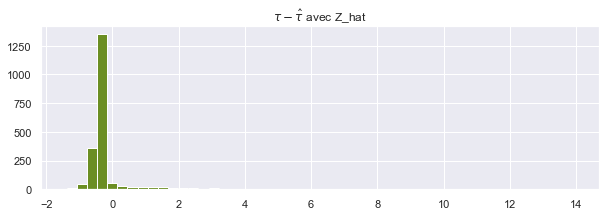

In [40]:
taus_l_Zhat, est_taus_l_Zhat = repeat_ests(a, b, beg, end, 2000, seed, "Z_hat")
stat_summary(taus_l_Zhat, est_taus_l_Zhat, "Z_hat")

Les biais augmentent un peu en valeur absolue pour les 3 méthodes. La méthode avec $\hat{Z}$ est devenu bien moins volatile : sa variance a chuté. Pour 8-means aussi la progression est nette et son estimateur pourrait rivaliser avec celui basé sur $\hat{Z}$.

- où le temps d'observation est allongé

In [41]:
mu = 0.1
a = 5
b = 10
beg = 0
end = 20

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:46<00:00, 43.16it/s]


----- Méthode: 2means -----
2000 estimations
biais: -1.60
variance: 56.25
mu=0.1
a=5
b=10


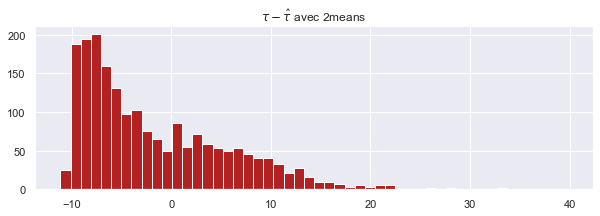

In [42]:
taus_l_2means, est_taus_l_2means = repeat_ests(a, b, beg, end, 2000, seed, "2means")
stat_summary(taus_l_2means, est_taus_l_2means, "2means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.20it/s]


----- Méthode: 8means -----
2000 estimations
biais: 1.06
variance: 12.44
mu=0.1
a=5
b=10


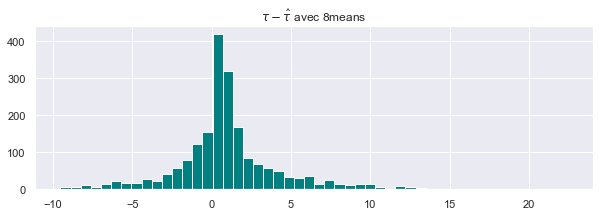

In [43]:
taus_l_8means, est_taus_l_8means = repeat_ests(a, b, beg, end, 2000, seed, "8means")
stat_summary(taus_l_8means, est_taus_l_8means, "8means")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:22<00:00, 24.36it/s]


----- Méthode: Z_hat -----
2000 estimations
biais: 0.31
variance: 21.32
mu=0.1
a=5
b=10


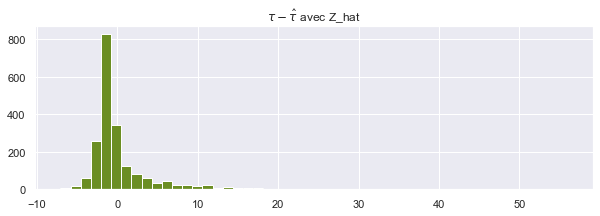

In [44]:
taus_l_Zhat, est_taus_l_Zhat = repeat_ests(a, b, beg, end, 2000, seed, "Z_hat")
stat_summary(taus_l_Zhat, est_taus_l_Zhat, "Z_hat")

On s'attendait à avoir des variances et biais plus élevés en valeur absolue qu'auparavant sachant que l'intervalle d'estimation de $\tau$ s'est _a priori_ élargi. Encore une fois des résultats médiocres avec 2-means. Cette fois-ci 8means concurrence sérieusement $\hat{Z}$ avec sa variance malgré son biais...

<hr>

Même si les estimations de $\tau$ avec $\hat{Z}$ ne sont pas toujours très fiables, elles restent globalement supérieures (sur des métriques statistiques simples) à celles obtenues par *k-means*.

**Conclusion : une heuristique un peu complexe est ici meilleure que du simple machine learning, bien que la prise en compte des paramètres connus  du problème nuance l'écart de performance**